In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('notebook')
from datetime import datetime, timedelta
import pymc3 as pm

/Users/daniel/.pyenv/versions/3.6.5/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
start_date = datetime(2020, 3, 1)
# end_date = datetime(2020, 4, 7)

In [4]:
df_cases = pd.read_csv('../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_deaths = pd.read_csv('../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

def clean_indices(df):
    df = df.set_index(['Province/State', 'Country/Region', 'Lat', 'Long'])
    df.columns = pd.to_datetime(df.columns)
    df = df.groupby('Country/Region').sum()
    df = df.T[start_date:]
    df.columns = df.columns.get_level_values('Country/Region')
    return df

df_cases = clean_indices(df_cases)
df_new_cases = (df_cases - df_cases.shift(1)).iloc[1:]
df_deaths = clean_indices(df_deaths)
df_new_deaths = (df_deaths - df_deaths.shift(1)).iloc[1:]
df_cases[:3]

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Yemen,Zambia,Zimbabwe
2020-03-01,1,0,1,0,0,0,0,1,27,14,...,36,0,0,0,16,0,0,0,0,0
2020-03-02,1,0,3,1,0,0,0,1,30,18,...,40,0,0,0,16,0,0,0,0,0
2020-03-03,1,0,5,1,0,0,1,1,39,21,...,51,0,0,0,16,0,0,0,0,0


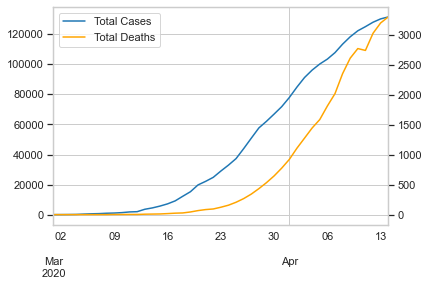

In [4]:
df_cases['Germany'].plot(legend=False)
ax = plt.gca()
ax2 = ax.twinx()
df_deaths['Germany'].plot(color='Orange', ax=ax2, legend=False)
ax2.grid(False)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
_ = ax2.legend(lines + lines2, ['Total Cases', 'Total Deaths'], loc=0)

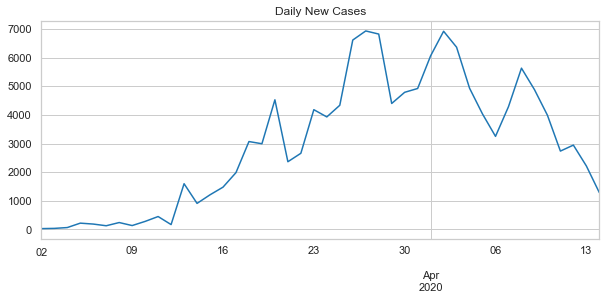

In [5]:
ger_daily = df_new_cases['Germany']
_ = ger_daily.plot(title='Daily New Cases', figsize=(10,4) ,legend=False)

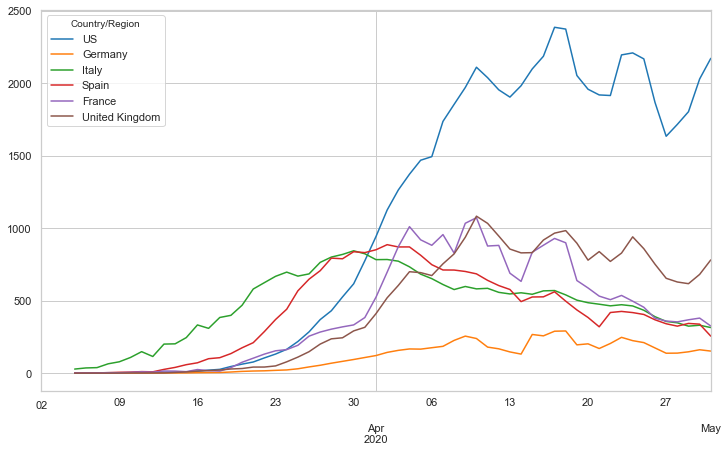

In [6]:
df_new_deaths[['US', 'Germany', 'Italy', 'Spain', 'France', 'United Kingdom']].rolling(4).mean().plot(figsize=(12,7))

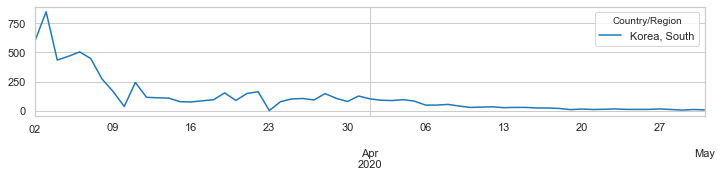

In [5]:
df_new_cases[['Korea, South']].plot(figsize=(12,2))

## Bayesian Trend Model

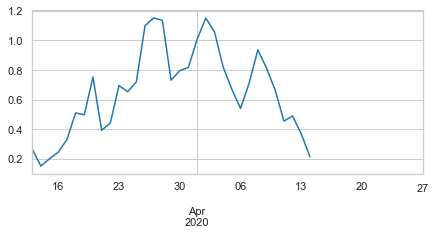

In [26]:
country = 'Germany'
days_to_forecast = 14

def rescale_input(s_input, n_days, data_end):
    df_input = s_input.to_frame()

    df_add = pd.DataFrame({s_input.name: None}, index=pd.date_range(df_input.index[-1], periods=days_to_forecast))[1:]
    df_input = pd.concat([df_input, df_add])

    df_input.columns = ['New Cases']
    df_input['Day Number'] = range(df_input.shape[0])
    df_input['Log New Cases'] = np.log(df_input['New Cases'])
    df_input['Normed Day'] = (df_input['Day Number'] - df_input['Day Number'].min()) / n_days
    case_range = df_input['New Cases'].max() - df_input['New Cases'].min()
    df_input['Normed New Cases'] = df_input['New Cases'] / case_range 

    df_input['Normed New Cases'].plot(figsize=(7,3))
    return df_input

s_input = df_new_cases[datetime(2020,3,13):][country]
n_days = (s_input.index.max() - s_input.index.min()).days
data_end = df_input.index[-1]
df_input = rescale_input(s_input, n_days, data_end)

In [27]:
# see https://www.ritchievink.com/blog/2018/10/09/build-facebooks-prophet-in-pymc3-bayesian-time-series-analyis-with-generalized-additive-models/

import theano
import theano.tensor as tt

def det_dot(a, b):
    """
    The theano dot product and NUTS sampler don't work with large matrices?
    
    :param a: (np matrix)
    :param b: (theano vector)
    """
    return (a * b[None, :]).sum(axis=-1)


def fourier_series(x, repeat=7, n_freqs=3):
    ''' creates the sin and cosine curves as numpy arrays
    over the full length of x.
    '''
    fourier = 2 * np.pi * np.arange(1, n_freqs + 1) / repeat
    fourier = fourier * x[:, None]
    fourier = np.concatenate((np.cos(fourier), np.sin(fourier)), axis=1)
    return fourier


n_changepoints = 4
change_points = np.linspace(0, 1, n_changepoints + 2)[:-1]
change_point_dist = (change_points[1] - change_points[0])
# matrix for vectorization of trend calculation (see blog post above)
A = (df_input[:data_end]['Normed Day'].values[:, None] >= change_points).astype(int)


with pm.Model() as model:
    start_cases = np.log(df_input['Normed New Cases'].iloc[0])
    
    # initial growth
    beta_zero = pm.Normal('beta_zero', 5, 2)
    #hyper_beta = pm.Gamma('hyper_beta', 7, 2)
    beta = pm.Normal('beta', 0, 1, shape=n_changepoints)

    # vectorized trend calculation (see blog post above)
    all_betas = pm.math.concatenate([beta_zero.flatten(), beta])
    trend_slope = det_dot(A, all_betas) * df_input[:data_end]['Normed Day']
    
    gamma = -np.array(change_points) * all_betas  
    conitnuity_correction = det_dot(A, gamma)
    trend = pm.Deterministic('trend', start_cases + trend_slope + conitnuity_correction)
    
    # day of week pattern
    n_frequencies = 3
    repeat = 7 / n_days
    fourier_curves = fourier_series(df_input[:data_end]['Normed Day'], repeat, n_frequencies)
    DOW_fourier_prior = pm.Gamma('DOW_fourier_prior', 5, 5)
    DOW_fourier_coeff = pm.Normal('DOW_fourier_coeff', mu=0, sd=DOW_fourier_prior, shape=2 * n_frequencies)
    
    DOW = pm.Deterministic('DOW', det_dot(fourier_curves, DOW_fourier_coeff))
    
    pm.Normal('obs', 
               mu=np.exp(trend + DOW),
               sigma=np.exp(trend + DOW) * 0.05 + 0.01,
               observed=df_input[:data_end]['Normed New Cases'])

/Users/daniel/.pyenv/versions/3.6.5/lib/python3.6/site-packages/pymc3/model.py:1430: ImputationWarning: Data in obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


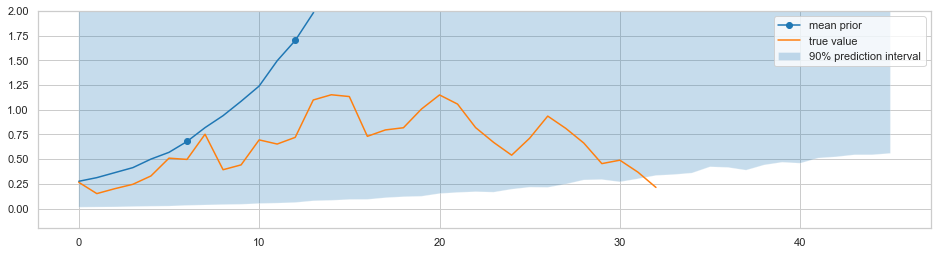

In [28]:
def sanity_check(true_value):
    """
    :param m: (pm.Model)
    :param df: (pd.DataFrame)
    """
    # Sample from the prior and check of the model is well defined.
    y = pm.sample_prior_predictive(samples=10000, model=model, vars=['obs'])['obs']
    plt.figure(figsize=(16, 4))
    plt.plot(np.median(y, 0), label='mean prior', markevery=list((change_points[1:] * n_days).astype(int)), marker='o')
    plt.fill_between(np.arange(y.shape[1]),
                     pd.DataFrame(y).quantile(0.05),
                     pd.DataFrame(y).quantile(0.95),
                     alpha=0.25, 
                     label='90% prediction interval')
    plt.plot(true_value.values, label='true value')
    plt.ylim([-0.2, 2])
    plt.legend()
    

# And run the sanity check
sanity_check(df_input['Normed New Cases'])

In [29]:
with model:
    trace = pm.sample(1000, tune=1000, step_scale=0.1)
    posterior = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [obs_missing, DOW_fourier_coeff, DOW_fourier_prior, beta, beta_zero]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [01:08<00:00, 116.99draws/s]
The acceptance probability does not match the target. It is 0.8871643130507143, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 4000/4000 [00:05<00:00, 675.95it/s]


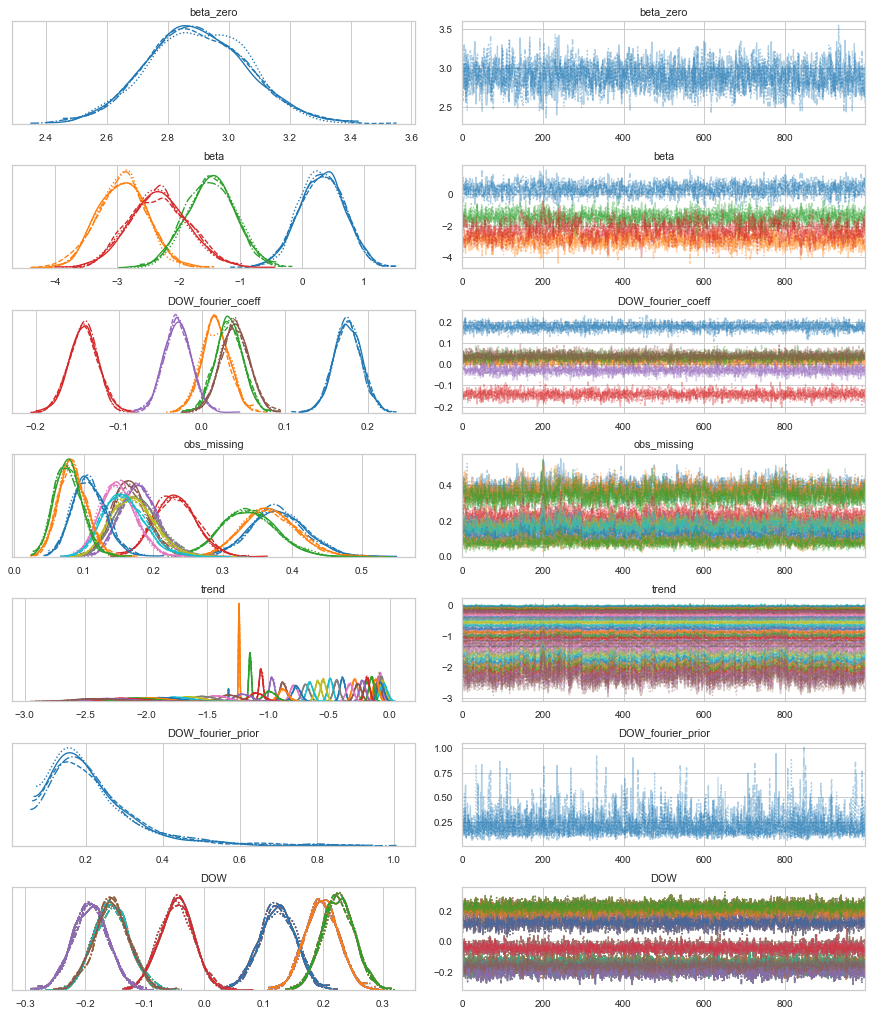

In [30]:
_ = pm.traceplot(trace)

In [32]:
def model_with_quantiles(model_values, alpha, mark_points):
    plot_with_q = model_values.apply(pd.Series.quantile, q=[alpha/2, 0.5, 1 - alpha/2]).T
    plot_with_q[0.5].plot(label='Model with Changepoint', figsize=(14,10), markevery=mark_points, marker='o')
    plt.fill_between(plot_with_q.index,
                     plot_with_q[alpha/2],
                     plot_with_q[1 - alpha/2], 
                     alpha=0.1,
                     label='95% prediction interval')
    
rescaled = (pd.DataFrame(posterior['obs']) * case_range  + df_input[:data_end]['New Cases'].min())
model_with_quantiles(rescaled, 0.05, list((change_points[1:] * n_days).astype(int)))

plt.plot((df_input[:data_end]['New Cases'].values), label='Johns Hopkins')
plt.legend()
# plt.yscale('log')

NameError: name 'case_range' is not defined

In [33]:
df_input.loc[:data_end, 'Model Normed New Cases'] = pd.DataFrame(posterior['obs']).median(axis=0).values
df_input['Model New Cases'] = df_input['Model Normed New Cases'] * case_range  + df_input[:data_end]['New Cases'].min() 

NameError: name 'case_range' is not defined

## Model changepoints (beta)

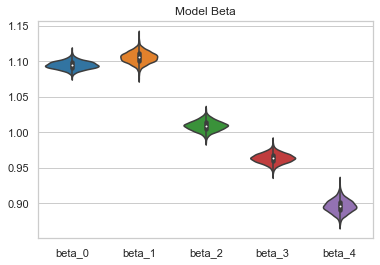

In [34]:
df_beta = pd.DataFrame(trace['beta'])
df_beta.columns = [f'beta_{i+1}' for i in df_beta.columns]
df_beta['beta_0'] = trace['beta_zero']
df_beta = df_beta[[f'beta_{i}' for i in range(0, n_changepoints + 1)]].copy()

df_beta_cum = df_beta.cumsum(axis=1)
# rescale
df_beta_cum = np.exp(df_beta_cum / n_days) 

sns.violinplot(data=df_beta_cum)
_ = plt.title('Model Beta')

## Forecast

In [ ]:
future_start = data_end + timedelta(days=1)
n_new_change_points = int(days_to_forecast / (change_point_dist * n_days)) + 1
new_change_points = np.array([change_points[-1] + (i + 1) * change_point_dist for i in range(n_new_change_points)])
# matrix for vectorization of trend calculation (see blog post above)
A2 = (df_input[future_start:]['Normed Day'].values[:, None] >= new_change_points).astype(int)

#hyper_beta = trace['hyper_beta']
n_samples = hyper_beta.shape[0]
beta_future = np.random.normal(0, 1, size=(n_new_change_points, n_samples)) 
beta_future[0,:] += beta_future[0,:] + df_beta_cum['beta_4'].values
np.median((A2 @ beta_future), axis=1)

In [ ]:
trend_slope_future = (A2 @ beta_future).T * df_input[future_start:]['Normed Day'].values
gamma_future = -np.array(new_change_points) * beta_future.T
conitnuity_correction_future = A2 @ gamma_future.T
trend_future = trend_slope_future + conitnuity_correction_future.T

fourier_curves_future = fourier_series(df_input[future_start:]['Normed Day'], repeat, n_frequencies)
DOW_future = fourier_curves_future @ trace['DOW_fourier_coeff'].T
trend_future = np.log(df_input['Model Normed New Cases'][data_end]) + trend_future + DOW_future.T
trend_future = pd.DataFrame(trend_future)
trend_future.columns = trend_future.columns + n_days + 1
trend_future[:3]

In [ ]:
np.median(trend_future, axis=0)

In [ ]:
np.median(DOW_future, axis=1)

In [ ]:
np.exp(trend_future)
past_future = pd.concat([pd.DataFrame(posterior['obs']), np.exp(trend_future)], axis=1) * case_range
all_chagenpoints = np.concatenate([change_points, new_change_points]) * n_days
model_with_quantiles(past_future, 0.1, list((all_chagenpoints[1:]).astype(int)))
plt.plot(np.exp(trend_future.median(axis=0)) * case_range)

In [ ]:
np.median(beta_future, axis=1)

In [914]:
np.median((A2 @ beta_future), axis=1)

array([], dtype=float64)

In [479]:
pd.DataFrame(trend_slope_future).median(axis=0)

0     0.963863
1     0.987959
2     1.012056
3     1.036152
4     1.060249
5     1.084346
6     1.108442
7     2.327974
8     2.377505
9     2.427037
10    2.476568
11    2.526099
12    2.575631
dtype: float64

In [452]:
pd.DataFrame(beta_future).median(axis=1)

0    0.969348
1    0.945866
dtype: float64

In [475]:
DOW_future.mean(axis=1)

array([ 0.00053698, -0.23181929, -0.15624682, -0.11399857,  0.09984663,
        0.13931855,  0.26236252,  0.00053698, -0.23181929, -0.15624682,
       -0.11399857,  0.09984663,  0.13931855])

## Distribution Playground

-21.380568108334575 20.34590921717659


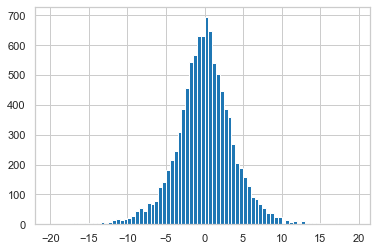

In [114]:
with pm.Model():
    b = pm.Gamma('hyper_beta', 7, 2)
    a = pm.Normal('beta', 0, b).random(size=10000)
    pd.Series(a).hist(bins=np.arange(-20, 20, 0.5))
    print(a.min(), a.max())

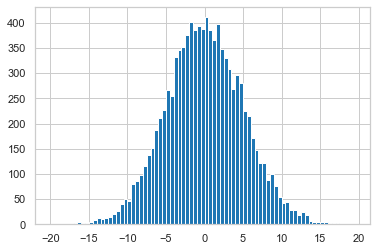

In [115]:
with pm.Model():
    a = pm.Normal('beta', 0, 5).random(size=10000)
    pd.Series(a).hist(bins=np.arange(-20, 20, 0.5))